In [25]:
%load_ext autoreload
%autoreload 2

from Openseas_Methods import pull_sales_data,make_graph,make_nft_graph,pull_nft_stats,edge_counts_to_percent
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import pygraphviz
import random
from pymongo import MongoClient
from tqdm import tqdm
import pandas as pd
from itertools import combinations
from collections import defaultdict
import ast
from decision_tree import get_eth_price
from pymongo import MongoClient

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
with open('combo_per.pkl','rb') as f:
   combo_perc =  pickle.load(f)
with open('Dino/pairwise_dist.pkl','rb') as f:
    dist_df = pickle.load(f)

In [27]:
dist_df['metric'] = dist_df.apply(lambda row: combo_perc.get((row['Label1'], row['Label2']), 0), axis=1)

In [28]:
metrics_df = pd.DataFrame(combo_perc, columns=['Label1', 'Label2', 'metric'])

In [29]:
dist_df_val = dist_df.query('metric>0')


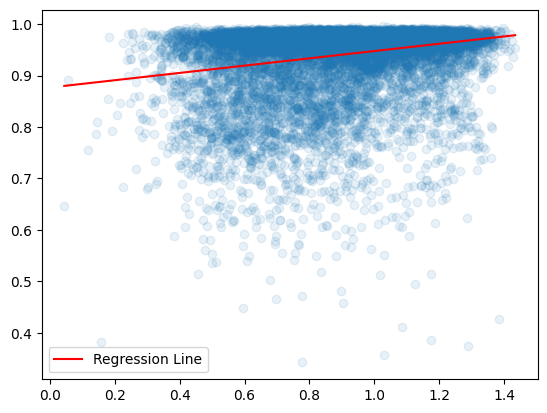

In [19]:
import matplotlib.pyplot as plt
import numpy as np
df_sorted = dist_df_val.sort_values(by='Distance')
x = df_sorted['Distance']
y = 1-df_sorted['metric']
plt.scatter(x,y,alpha=0.1)
slope, intercept = np.polyfit(x, y, 1)
plt.plot(x, slope * x + intercept, color='red', label='Regression Line')
plt.legend()
plt.show()

In [40]:
from scipy.stats import pearsonr

pearsonr(x,y)

PearsonRResult(statistic=0.23318506932986016, pvalue=2.37991426501572e-170)

In [3]:
client = MongoClient()
db = client.NFTDB
collection_data = db.salesCollection
stats_collection = db.NFTStats
slug_collection = db.completedSlugs
combos = db.NFT
skip_list=['ens','base-introduced','fundrop-pass','gemesis','apecoin','dai-stablecoin','uniswap','1inch-token']

In [4]:
with open('combo_per.pkl','rb') as f:
    combo_perc = pickle.load(f)
G = make_nft_graph(list(combo_perc.items()),skip_list=skip_list)
comms = nx.community.greedy_modularity_communities(G,weight='weight')

In [8]:
list_comms = [list(x) for x in comms]

In [32]:
dist_df_val['label2_Index'] = dist_df_val['Label2'].apply(lambda x: string_to_sublist.get(x, None))

/tmp/ipykernel_35261/4120641791.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dist_df_val['label2_Index'] = dist_df_val['Label2'].apply(lambda x: string_to_sublist.get(x, None))


In [11]:
string_to_sublist = {string: index for index, sublist in enumerate(list_comms) for string in sublist}

In [34]:
dist_df_val['label2_Index'].describe()

count    13847.000000
mean         0.430707
std          0.936727
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: label2_Index, dtype: float64

                    Label1                        Label2  Distance    metric  \
15820                azuki               azukielementals  0.117522  0.244050   
90049        noble-gallery                  thememes6529  0.143221  0.214318   
56072      food-for-degens  open-edition-by-kevin-abosch  0.145597  0.189809   
31010          clickcreate                 noble-gallery  0.179239  0.145711   
39129        crypto-phunks                     nakamigos  0.181515  0.025072   
...                    ...                           ...       ...       ...   
55148      fluf-world-eggs     rug-radio-membership-pass  1.417052  0.019435   
59054          gen-dot-art     rug-radio-membership-pass  1.417990  0.048725   
23556  bored-and-dangerous                floor-app-pass  1.423674  0.032186   
83759           mntge-pass     rug-radio-membership-pass  1.426424  0.064211   
50754      end-of-sartoshi     rug-radio-membership-pass  1.433910  0.046259   

       label1_Index  label2_Index  
158

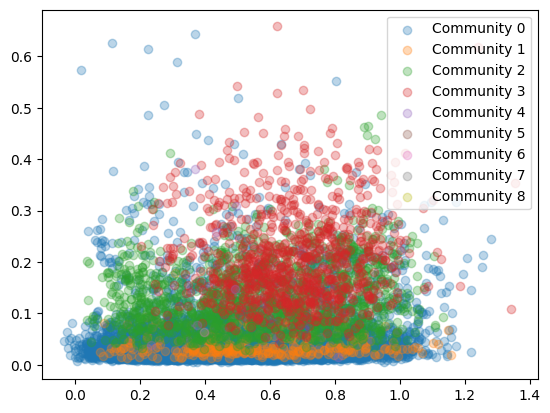

In [45]:
import matplotlib.pyplot as plt
import numpy as np
for comm_idx in range(0,9):
    df_sorted = dist_df_val.sort_values(by='Distance')
    df_comm = df_sorted.query(f'label1_Index == {comm_idx} and label2_Index == {comm_idx}')
    print(df_comm)
    x = 1.4-df_comm['Distance']
    y = df_comm['metric']
    try:
        plt.scatter(x,y,alpha=0.3,label=f'Community {comm_idx}')
        # slope, intercept = np.polyfit(x, y, 1)
        # plt.plot(x, slope * x + intercept, color='red', label='Regression Line')
        plt.legend()
    except:
        continue

                    Label1                     Label2  Distance    metric  \
25332    boredapeyachtclub      mutant-ape-yacht-club  0.383347  0.165948   
15841                azuki          boredapeyachtclub  0.390299  0.052497   
25279    boredapeyachtclub                 lazy-lions  0.393059  0.010838   
16274      azukielementals          boredapeyachtclub  0.401531  0.027139   
25242    boredapeyachtclub              guttercatgang  0.411988  0.060827   
...                    ...                        ...       ...       ...   
25428    boredapeyachtclub  rug-radio-membership-pass  1.226822  0.013484   
25226    boredapeyachtclub                   gearpods  1.245957  0.047376   
25222    boredapeyachtclub                foundersdao  1.251268  0.042613   
23482  bored-and-dangerous          boredapeyachtclub  1.258686  0.046938   
25208    boredapeyachtclub                firstdayout  1.263352  0.010428   

       label1_Index  label2_Index  
25332             0             0  
158

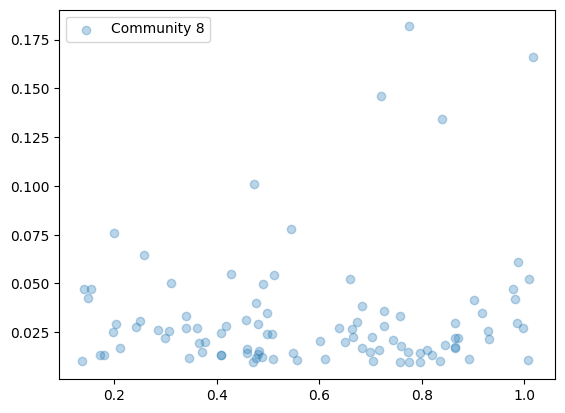

In [50]:
import matplotlib.pyplot as plt
import numpy as np
df_sorted = dist_df_val.sort_values(by='Distance')
nft_slug = 'boredapeyachtclub'
df_comm = df_sorted.query(f"Label1 == '{nft_slug}' or Label2 == '{nft_slug}'")
print(df_comm)
x = 1.4-df_comm['Distance']
y = df_comm['metric']
plt.scatter(x,y,alpha=0.3,label=f'Community {comm_idx}')
# slope, intercept = np.polyfit(x, y, 1)
# plt.plot(x, slope * x + intercept, color='red', label='Regression Line')
plt.legend()


In [51]:
from scipy.stats import pearsonr

pearsonr(x,y)

PearsonRResult(statistic=0.11905017141337, pvalue=0.24297908034297885)